In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa

import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
import keras
import warnings
from keras.utils import Sequence
warnings.filterwarnings("ignore")
SIZE = 299
SEED = 777
THRESHOLD = 0.2

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
# Load dataset info
DIR = '../input/'
data = pd.read_csv('../input/train.csv')


In [4]:
def getTrainDataset():
    
    path_to_train = DIR + '/train/'
    data = pd.read_csv(DIR + '/train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = DIR + '/test/'
    data = pd.read_csv(DIR + '/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)
paths, labels = getTrainDataset()

In [5]:
# credits: https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
# credits: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
from random import randint
class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, channels = [], shuffle = False, use_cache = False, augmentor = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.channels = channels
        self.augmentor = augmentor
        self.clahe = cv2.createCLAHE()
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], len(channels)))
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]

        #X=[np.expand_dims(x, 3) for x in np.split(X, len(self.channels), -1)]
        #X=np.split(X, len(self.channels), -1)

        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            if self.augmentor == True:
                item = self.augment(item)
            yield item
            
    def __load_image(self, path):
        images = []
        for channel in self.channels:
            im = np.array(Image.open(path + '_' + channel + '.png'))
            
            im = clahe.apply(im)
            images.append(im)
            
        if len(self.channels) >= 2:
            im = np.stack((
                images
            ), -1)
            im = cv2.resize(im, (SIZE,SIZE))
            im = np.divide(im, 255)

        else:
            im = images[0]
            im = cv2.resize(im, (SIZE,SIZE))
            im = np.divide(im, 255)
            im = np.expand_dims(im, 2)
        return im
    def augment(self, image):
        if randint(0,1) == 1:
            augment_img = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Flipud(0.5), # horizontal flips
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                        rotate=(-180, 180),
                        shear=(-4, 4)
                    )
                ])], random_order=True)


            image_aug = augment_img.augment_image(image)
            return image_aug
        else:
            return image
    

In [6]:
SHAPE = (299, 299, 4)

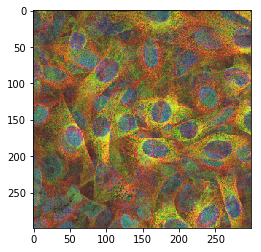

In [7]:
channels = ["red", "green", "blue", "yellow"]
for path in paths[0:10]:
    images = []
    for channel in channels:
        im = np.array(Image.open(path + '_' + channel + '.png'))
#         im = cv2.equalizeHist(im)
        clahe = cv2.createCLAHE()
        im = clahe.apply(im)
#         plt.imshow(im)
        images.append(im)

    if len(channels) >= 2:
        im = np.stack((
            images
        ), -1)
        im = cv2.resize(im, (SIZE,SIZE))
        im = np.divide(im, 255)
        
        
    else:
        im = images[0]
        im = cv2.resize(im, (SIZE,SIZE))
        im = np.divide(im, 255)
        im = np.expand_dims(im, 2)
    plt.imshow(im)

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization
from keras.layers import concatenate, Input, Conv2D, MaxPooling2D, Conv3D, MaxPooling3D, Lambda, Permute
from keras.layers import LSTM, Concatenate, Reshape, CuDNNLSTM
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model
from keras.utils import multi_gpu_model

In [9]:
lstmUnits = 64

In [10]:
def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)
def f1_loss(y_true, y_pred):
    
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

In [11]:
# create callbacks list
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

epochs = 100; batch_size = 32;VAL_RATIO = .1;DEBUG = False
# split data into train, valid
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

if DEBUG == True:  # use only small subset for debugging, Kaggle's RAM is limited
    pathsTrain = paths[0:256]
    labelsTrain = labels[0:256]
    pathsVal = paths[lastTrainIndex:lastTrainIndex+256]
    labelsVal = labels[lastTrainIndex:lastTrainIndex+256]
    use_cache = True
else:
    pathsTrain = paths[0:lastTrainIndex]
    labelsTrain = labels[0:lastTrainIndex]
    pathsVal = paths[lastTrainIndex:]
    labelsVal = labels[lastTrainIndex:]
    use_cache = False

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)
use_cache = False
channels = ["green", "blue", "red", "yellow"]
tg = ProteinDataGenerator(pathsTrain, labelsTrain, batch_size, SHAPE, channels, use_cache=use_cache, augmentor = True)
vg = ProteinDataGenerator(pathsVal, labelsVal, batch_size, SHAPE, channels, use_cache=use_cache, augmentor = False)

(31072,) (31072, 28)
(27964,) (27964, 28) (3108,) (3108, 28)


In [12]:
checkpoint = ModelCheckpoint('../working/SimpleWithSemanticCorrelation.h5', monitor='val_f1', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_f1', factor=0.5, patience=4, 
                                   verbose=1, mode='max', epsilon=0.0001)
early = EarlyStopping(monitor="val_f1", 
                      mode="max", 
                      patience=5)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [13]:
def create_model(n_out, channels):
    input_tensor = Input(shape=(299,299,len(channels)))

    ### Naive implementation results in VERY LARGE number of timesteps
    ### Large enough to kill the machine at training time
    #input_width = Reshape((299*299, len(channels)))(input_tensor)
    #input_height= Reshape((299*299, len(channels)))(Permute((2, 1, 3))(input_tensor))
    #lstm_width = LSTM(lstmUnits, return_sequences=False)(input_width)
    #lstm_height = LSTM(lstmUnits, return_sequences=False)(input_height)
    
    ### So, as the solution, we'll use a few convolution+maxpooling layers to get
    ### number of time steps to reasonable size
    bn = BatchNormalization()(input_tensor)
    x = Conv2D(8, kernel_size=(3,3), activation='relu', padding = "same")(bn)
    x = Conv2D(8, kernel_size=(3,3), activation='relu', padding = "same")(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Conv2D(16, kernel_size=(3,3), activation='relu', padding = "same")(x)
    x = Conv2D(16, kernel_size=(3,3), activation='relu', padding = "same")(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Conv2D(32, kernel_size=(3,3), activation='relu', padding = "same")(x)
    x = Conv2D(32, kernel_size=(3,3), activation='relu', padding = "same")(x)
    x = MaxPooling2D(pool_size = (2,2))(x)

    shape=K.int_shape(x)
    shape=(shape[1]*shape[2], shape[3])
    input_width = Reshape(shape)(x)
    input_height= Reshape(shape)(Permute((2,1,3))(x))
    print(input_width)
    print(input_height)
    lstm_width = CuDNNLSTM(lstmUnits, return_sequences=False)(input_width)
    lstm_height = CuDNNLSTM(lstmUnits, return_sequences=False)(input_height)

    x = Concatenate()([lstm_width, lstm_height])
    #x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
#     output = Dense(n_out, activation='sigmoid')(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [14]:
# warm up model
import tensorflow as tf
model = create_model(n_out=28, channels = channels)
model.summary()


Tensor("reshape_1/Reshape:0", shape=(?, 1369, 32), dtype=float32)
Tensor("reshape_2/Reshape:0", shape=(?, 1369, 32), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 4)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 299, 299, 4)  16          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 299, 299, 8)  296         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 299, 299, 8)  584         conv2d_1[0]

2.2.4


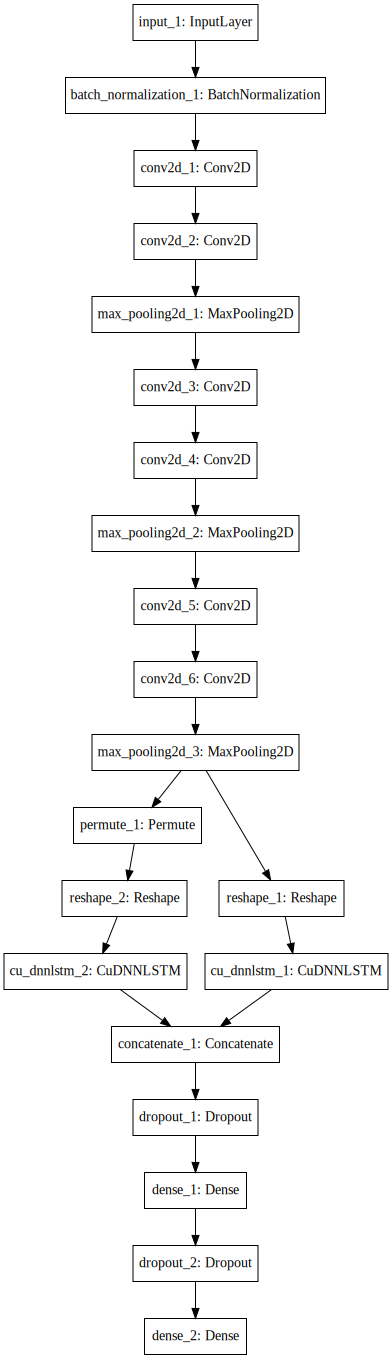

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
print(keras.__version__)
SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [16]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=Adam(1e-03),
    metrics=['binary_accuracy', f1])

In [17]:
hist =  model.fit_generator(
        tg,
        steps_per_epoch=np.ceil(float(len(pathsTrain)) / float(batch_size)),
        validation_data=vg,
        validation_steps=np.ceil(float(len(pathsVal)) / float(batch_size)),
        epochs=50, 
        verbose=1,
        callbacks = callbacks_list)

Epoch 1/50
874/874 [==============================] - 345s 395ms/step - loss: 0.1819 - binary_accuracy: 0.9399 - f1: 0.0442 - val_loss: 0.1744 - val_binary_accuracy: 0.9412 - val_f1: 0.0519

Epoch 00001: val_f1 improved from -inf to 0.05190, saving model to ../working/SimpleWithSemanticCorrelation.h5
Epoch 2/50
874/874 [==============================] - 357s 409ms/step - loss: 0.1699 - binary_accuracy: 0.9431 - f1: 0.0517 - val_loss: 0.1653 - val_binary_accuracy: 0.9455 - val_f1: 0.0576

Epoch 00002: val_f1 improved from 0.05190 to 0.05760, saving model to ../working/SimpleWithSemanticCorrelation.h5
Epoch 3/50
874/874 [==============================] - 347s 397ms/step - loss: 0.1647 - binary_accuracy: 0.9462 - f1: 0.0573 - val_loss: 0.1614 - val_binary_accuracy: 0.9462 - val_f1: 0.0671

Epoch 00003: val_f1 improved from 0.05760 to 0.06714, saving model to ../working/SimpleWithSemanticCorrelation.h5
Epoch 4/50
874/874 [==============================] - 345s 395ms/step - loss: 0.1619 - b

874/874 [==============================] - 354s 404ms/step - loss: 0.1177 - binary_accuracy: 0.9583 - f1: 0.2347 - val_loss: 0.1190 - val_binary_accuracy: 0.9566 - val_f1: 0.2323

Epoch 00030: val_f1 did not improve from 0.24283
Epoch 31/50
874/874 [==============================] - 356s 408ms/step - loss: 0.1170 - binary_accuracy: 0.9587 - f1: 0.2349 - val_loss: 0.1177 - val_binary_accuracy: 0.9578 - val_f1: 0.2483

Epoch 00031: val_f1 improved from 0.24283 to 0.24829, saving model to ../working/SimpleWithSemanticCorrelation.h5
Epoch 32/50
874/874 [==============================] - 354s 405ms/step - loss: 0.1157 - binary_accuracy: 0.9592 - f1: 0.2391 - val_loss: 0.1177 - val_binary_accuracy: 0.9579 - val_f1: 0.2485

Epoch 00032: val_f1 improved from 0.24829 to 0.24854, saving model to ../working/SimpleWithSemanticCorrelation.h5
Epoch 33/50
874/874 [==============================] - 354s 405ms/step - loss: 0.1146 - binary_accuracy: 0.9596 - f1: 0.2428 - val_loss: 0.1192 - val_binary_ac

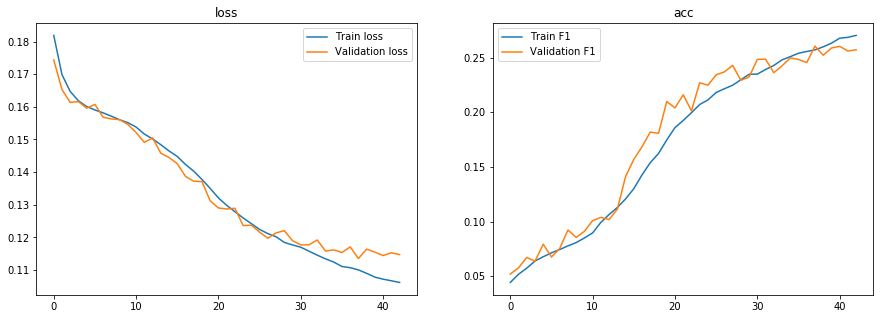

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1")
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [19]:
from keras.models import load_model
bestModel = load_model('../working/SimpleWithSemanticCorrelation.h5', custom_objects={'f1': f1, 'f1_loss': f1_loss})

In [20]:
from tqdm import tqdm
lastFullValPred = np.empty((0, 28))
lastFullValLabels = np.empty((0, 28))
for i in tqdm(range(len(vg))): 
    im, lbl = vg[i]
    scores = bestModel.predict(im)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
print(lastFullValPred.shape, lastFullValLabels.shape)

100%|██████████| 98/98 [00:42<00:00,  2.32it/s]

(3108, 28) (3108, 28)


In [21]:
from sklearn.metrics import f1_score as off1
rng = np.arange(0, 1, 0.001)
f1s = np.zeros((rng.shape[0], 28))
for j,t in enumerate(tqdm(rng)):
    for i in range(28):
        p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
        scoref1 = off1(lastFullValLabels[:,i], p, average='binary')
        f1s[j,i] = scoref1

100%|██████████| 1000/1000 [00:18<00:00, 54.17it/s]


Individual F1-scores for each class:
[0.8        0.81451613 0.68235294 0.41025641 0.66288952 0.37819026
 0.46153846 0.52671756 0.12903226 0.5        0.66666667 0.52777778
 0.36444444 0.30630631 0.78504673 0.00518135 0.13846154 0.11764706
 0.22       0.2706422  0.08333333 0.58858859 0.45631068 0.68789809
 0.4        0.62813299 0.12068966 0.        ]
Macro F1-score CV = 0.41902217641416845
Probability threshold maximizing CV F1-score for each class:
[0.511 0.304 0.455 0.187 0.368 0.133 0.23  0.372 0.04  0.116 0.109 0.19
 0.199 0.252 0.412 0.002 0.093 0.223 0.111 0.157 0.077 0.298 0.227 0.284
 0.208 0.303 0.044 0.   ]


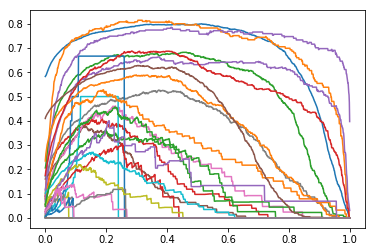

In [22]:
print('Individual F1-scores for each class:')
print(np.max(f1s, axis=0))
print('Macro F1-score CV =', np.mean(np.max(f1s, axis=0)))
plt.plot(rng, f1s)
T = np.empty(28)
for i in range(28):
    T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
print('Probability threshold maximizing CV F1-score for each class:')
print(T)

In [23]:
pathsTest, labelsTest = getTestDataset()

testg = ProteinDataGenerator(pathsTest, labelsTest, batch_size, SHAPE, channels)
submit = pd.read_csv(DIR + '/sample_submission.csv')
P = np.zeros((pathsTest.shape[0], 28))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = bestModel.predict(images)
    P[i*batch_size:i*batch_size+score.shape[0]] = score

100%|██████████| 366/366 [02:39<00:00,  2.30it/s]


In [24]:
PP = np.array(P)

In [25]:
prediction = []

for row in tqdm(range(submit.shape[0])):
    
    str_label = ''
    
    for col in range(PP.shape[1]):
        if(PP[row, col] < T[col]):
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())
    
submit['Predicted'] = np.array(prediction)
submit.to_csv('../output/SimpleWithRNN.csv', index=False)

100%|██████████| 11702/11702 [00:00<00:00, 87876.96it/s]
